## Import packages

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf') # note that we need to have tensorflow dimension ordering still because of the weigths.
print('The backend is:',K.backend())
import tensorflow as tf
print(K.image_dim_ordering()) # should say tf
print(tf.__version__) # tested for 1.11.0

import keras
print(keras.__version__) # tested for 2.2.4

Using TensorFlow backend.


The backend is: tensorflow
tf
1.9.0
2.2.2


In [3]:
# Import relevant packages
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
import h5py # to handle weights
import os, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
np.random.seed(150)

import sklearn
from sklearn.model_selection import train_test_split

import cv2

## Load in and process data

In [4]:
map_data = pd.read_pickle('position_df.pkl')

In [5]:
# Resize from 640 * 640 * 3 to 150 * 150 * 3
map_data['image'] = map_data['image'].apply(lambda x: cv2.resize(x,(150,150)))

In [6]:
map_data.drop(['location','index'],axis=1,inplace=True)

In [7]:
map_data.iloc[0,1].shape

(150, 150, 3)

In [ ]:
map_data.head()

In [8]:
for i in range(0,len(map_data)):
    if map_data.iloc[i,0] != 0:
        map_data.iloc[i,0] = 1

In [9]:
map_data['label'].describe()

count     3493
unique       2
top          1
freq      2793
Name: label, dtype: int64

In [10]:
map_data_nonzero = map_data[map_data['label']!=0]
map_data_nonzero = map_data_nonzero.sample(700)

In [11]:
map_data_zero = map_data[map_data['label']==0]

In [12]:
map_data_new = pd.concat([map_data_nonzero,map_data_zero])

In [13]:
# Read X and y data
Xs = np.array(map_data_new.iloc[:,1].tolist())
ys = np.array(map_data_new.iloc[:,0])

In [14]:
Xs.shape

(1400, 150, 150, 3)

In [15]:
ys.shape

(1400,)

In [16]:
# Split data into training data (including training and validation) and test data
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 0)

# Split training data into true training data and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [17]:
# confirm the shape and type of our data is right
print('The length of X_train is', len(X_train))

print('The length of X_val is', len(X_val))

print('The length of X_test is', len(X_test))

print('The length of y_train is', len(y_train))

print('The length of y_val is', len(y_val))

print('The length of y_test is', len(y_test))

The length of X_train is 896
The length of X_val is 224
The length of X_test is 280
The length of y_train is 896
The length of y_val is 224
The length of y_test is 280


In [18]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [19]:
# One hot encoding
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

In [71]:
# First type of CNN model
input_size=(150,150,3)
num_classes=2

def createCNNModel(num_classes):

    # Create the model
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=input_size, border_mode='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 3  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model, epochs

# create our CNN model
model, epochs = createCNNModel(num_classes)
print("CNN Model created.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               92160512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [72]:
X_train.shape

(896, 150, 150, 3)

In [73]:
#batch size，learning rate can be modified before training

batch_size=60
seed = 7
np.random.seed(seed)
model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = epochs)

Epoch 1/3
896/896 [==============================] - 1089s 1s/step - loss: 1.1478 - acc: 0.5268
Epoch 2/3
896/896 [==============================] - 918s 1s/step - loss: 0.6394 - acc: 0.6317
Epoch 3/3
896/896 [==============================] - 1024s 1s/step - loss: 0.5649 - acc: 0.7232


In [74]:
# Final evaluation of the model on test
scores = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model on test
scores = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model on test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

print("done")

Training Accuracy: 72.88%
Validation Accuracy: 67.41%
Test Accuracy: 69.29%
done


In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               92160512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [76]:
model.save('cnn_trial_start.h5')

In [77]:
y_pred=model.predict(X_test)
print("y_pred is \n",y_pred)

y_pred is 
 [[0.4920656  0.5079344 ]
 [0.32645875 0.6735412 ]
 [0.4348982  0.56510186]
 [0.5827406  0.4172594 ]
 [0.5627554  0.4372446 ]
 [0.56299585 0.43700418]
 [0.31305015 0.68694985]
 [0.2337516  0.7662484 ]
 [0.31229612 0.6877039 ]
 [0.29001385 0.70998615]
 [0.15422845 0.8457716 ]
 [0.77416646 0.22583345]
 [0.404603   0.595397  ]
 [0.39038008 0.6096199 ]
 [0.31270534 0.68729466]
 [0.47279662 0.5272034 ]
 [0.39233947 0.60766053]
 [0.28455782 0.7154422 ]
 [0.17590758 0.8240924 ]
 [0.43246666 0.5675333 ]
 [0.37370202 0.626298  ]
 [0.7644951  0.23550493]
 [0.5393179  0.46068212]
 [0.43461955 0.56538045]
 [0.40870988 0.5912901 ]
 [0.6015911  0.39840895]
 [0.24816188 0.7518381 ]
 [0.26521102 0.73478895]
 [0.49146837 0.5085316 ]
 [0.64812803 0.351872  ]
 [0.30724472 0.6927553 ]
 [0.4399357  0.5600644 ]
 [0.5868005  0.4131995 ]
 [0.45100808 0.5489919 ]
 [0.33585078 0.66414917]
 [0.40744862 0.59255135]
 [0.6031721  0.39682782]
 [0.57545793 0.4245421 ]
 [0.22052225 0.7794778 ]
 [0.36929613 

In [ ]:
def final_pred(pred):
    for idx in range(0,len(pred)):
        if pred[idx][0] > pred[idx][1]:
            print('SAFE!')
        elif pred[idx][0] == pred[idx][1]:
            print('CANNOT TELL!')
        else:
            print('DANGEROUS!')

In [ ]:
def convert_pred(pred):
    pred_result = []
    for idx in range(0,len(pred)):
        if pred[idx][0] >= pred[idx][1]:
            pred_result.append(0)
        else:
            pred_result.append(1)
    return pred_result

In [ ]:
final = convert_pred(y_pred)

In [21]:
from os import listdir
from os.path import isfile, join

In [58]:
import matplotlib

In [61]:
def plot_pic(idx):
    # img here should be a number
    # an index to locate this image in the map_data dataframe
    pic = X_test[idx]
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()
    
    # Save images again
    matplotlib.image.imsave('test/testimage'+str(idx)+'.png', pic)

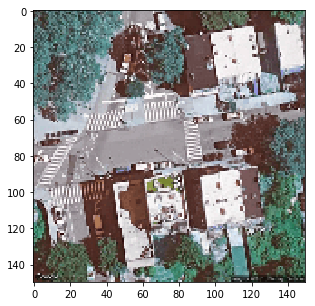

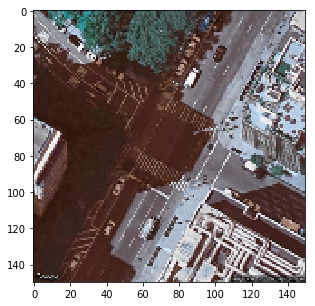

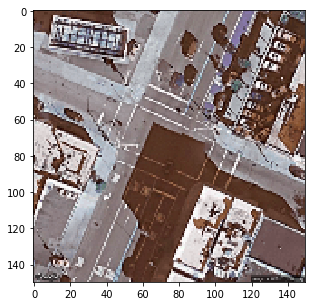

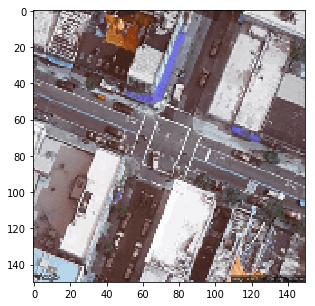

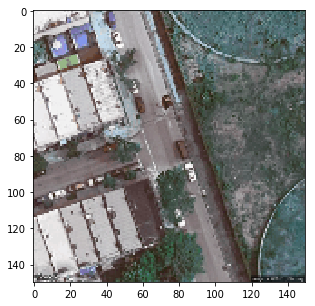

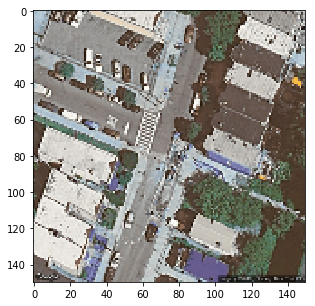

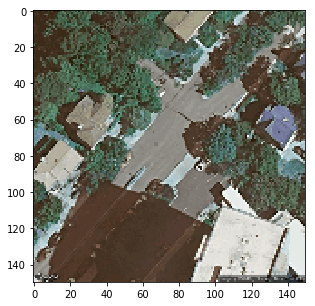

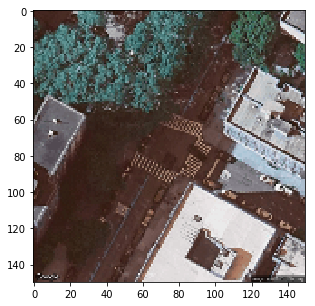

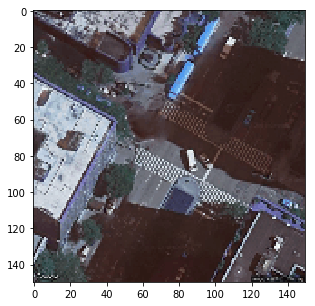

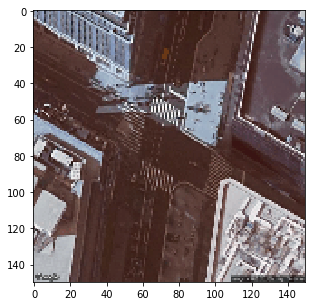

In [62]:
for idx in range(0,10):
    plot_pic(idx)

In [65]:
# list of lists, containing logistic regression for each file
prediction_output_list = []  
fnames = [f for f in listdir("test/") if isfile(join("test/", f))]
print("Testing File Names:")
print(fnames)

Testing File Names:
['testimage0.png', 'testimage1.png', 'testimage2.png', 'testimage3.png', 'testimage4.png', 'testimage5.png', 'testimage6.png', 'testimage7.png', 'testimage8.png', 'testimage9.png']


In [79]:
# early stoppage...
# only do 10
i = 0
for f in fnames:
    file_name = "test/" + f
    print("---Evaluating File at: " + file_name)
    
    img = cv2.imread(file_name)  
    # resize so we're always comparing same-sized images
    imlist = np.array(img)
    print("Neural Net Prediction:")
    
    cnn_prediction = model.predict_proba(imlist)
    print(cnn_prediction)
    
    # format list for csv output
    csv_output_list = []
    csv_output_list.append(f)
    for elem in cnn_prediction:
        for value in elem:
            csv_output_list.append(value)

    # append filename to make sure we have right format to write to csv
    print("CSV Output List Formatted:")
    print(csv_output_list)

    # and append this file to the output_list (of lists)
    prediction_output_list.append(csv_output_list)
        
    ############## STOP EARLY TO SAVE TIME #################
    if i > 10:
        break
    i += 1
    #####  REMOVE TO RUN AGAINST FULL TEST SET ########

    # Write to csv
    #with open("cnn_predictions.csv", "wb") as f:
    #    writer = csv.writer(f)
    #    headers = ['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    #    writer.writerow(headers)
    #    writer.writerows(prediction_output_list)
    #    f.close()

---Evaluating File at: test/testimage0.png
Neural Net Prediction:


ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (150, 150, 3)